In [1]:
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import pickle, os, sys

In [3]:
!ls ../../externals/ERGO-II/Samples

ls: ../../externals/ERGO-II/Samples: No such file or directory


In [4]:
!pwd

/Users/kyoheikoyama/workspace/TCRPrediction/eda


In [5]:
# !ls ../data/
!ls ../../../data/

Seq_multi.fasta       protein.data          train_src
Seq_solo.fasta        protein_with_bio.data train_src_bio
all_src.npy           sec                   train_tgt
all_tgt.npy           test_src              val_src
cdrmap                test_src_bio          val_src_bio
cdrmap.tsv            test_tgt              val_tgt


# ERGO2: Data Overview

In [6]:
ERGODIR = '../../external_data/'

In [7]:
data_dictionary = {
    f.replace('.pickle',''): pd.DataFrame(pickle.load(open(os.path.join(ERGODIR, f'ERGO-II/Samples/{f}'), 'rb')))
    for f in os.listdir(os.path.join(ERGODIR, f'ERGO-II/Samples'))
}

In [8]:
print(data_dictionary.keys())

dict_keys(['vdjdb_test_samples', 'vdjdb_no10x_test_samples', 'mcpas_test_samples', 'vdjdb_train_samples', 'mcpas_train_samples', 'vdjdb_no10x_train_samples'])


In [9]:
remove_unk = lambda df: df[df.tcra!='UNK']

In [10]:
data_dictionary = {k:remove_unk(v) for k,v in data_dictionary.items()}

In [11]:
def add_pairs(df):
    df['pairs'] = df['tcra'] + ":" + df['tcrb'] + ":" + df['peptide']
    df['tcr_pairs'] = df['tcra'] + ":" + df['tcrb']
    return df

def delete_duplicated_interactions(tr, te):
    te['pairs'] = te['tcra'] + ":" + te['tcrb'] + ":" + te['peptide']
    return te[~te.pairs.isin(tr.pairs)]
    

In [12]:
vdjdb_train_samples       = add_pairs(remove_unk(data_dictionary['vdjdb_train_samples']))
vdjdb_test_samples        = add_pairs(remove_unk(data_dictionary['vdjdb_test_samples']))
mcpas_train_samples       = add_pairs(remove_unk(data_dictionary['mcpas_train_samples']))
mcpas_test_samples        = add_pairs(remove_unk(data_dictionary['mcpas_test_samples']))
vdjdb_no10x_train_samples = add_pairs(remove_unk(data_dictionary['vdjdb_no10x_train_samples']))
vdjdb_no10x_test_samples  = add_pairs(remove_unk(data_dictionary['vdjdb_no10x_test_samples']))


In [13]:
vdjdb_test_samples = delete_duplicated_interactions(vdjdb_train_samples, vdjdb_test_samples)
mcpas_test_samples = delete_duplicated_interactions(mcpas_train_samples, mcpas_test_samples)
vdjdb_no10x_test_samples = delete_duplicated_interactions(vdjdb_no10x_train_samples, vdjdb_no10x_test_samples)


data_dictionary['vdjdb_train_samples'] = vdjdb_train_samples
data_dictionary['vdjdb_test_samples'] = vdjdb_test_samples

data_dictionary['mcpas_train_samples'] = mcpas_train_samples
data_dictionary['mcpas_test_samples'] = mcpas_test_samples

data_dictionary['vdjdb_no10x_train_samples'] = vdjdb_no10x_train_samples
data_dictionary['vdjdb_no10x_test_samples'] = vdjdb_no10x_test_samples


In [14]:
for ky, df in data_dictionary.items():
    print(ky, df.shape)
    print(df.tcra.nunique())
    print(df.tcrb.nunique())
    print(df.peptide.nunique())

vdjdb_test_samples (27638, 13)
4146
4221
150
vdjdb_no10x_test_samples (4010, 13)
570
572
119
mcpas_test_samples (4729, 13)
718
714
190
vdjdb_train_samples (116560, 13)
13894
14640
200
mcpas_train_samples (23363, 13)
2423
2560
316
vdjdb_no10x_train_samples (19526, 13)
2151
2171
175


# All combined ver

In [15]:
# dfall_1 = pd.concat([
#     data_dictionary['vdjdb_train_samples'], data_dictionary['mcpas_train_samples'],
#     data_dictionary['vdjdb_test_samples'],  data_dictionary['mcpas_test_samples'],
# #     data_dictionary['vdjdb_no10x_train_samples'], data_dictionary['vdjdb_no10x_test_samples'],
# ])

In [16]:
# dfall_1.drop_duplicates(subset=['tcra','tcrb','peptide'])

In [17]:
dfall_2 = pd.concat([
    data_dictionary['vdjdb_train_samples'], data_dictionary['mcpas_train_samples'],
    data_dictionary['vdjdb_test_samples'],  data_dictionary['mcpas_test_samples'],
#     data_dictionary['vdjdb_no10x_train_samples'], data_dictionary['vdjdb_no10x_test_samples'],
])

dfall_2 = add_pairs(dfall_2)
dfall_2[['tcra','tcrb','peptide']].nunique()

tcra       17954
tcrb       19162
peptide      478
dtype: int64

In [18]:
dfall_2.shape

(172290, 13)

In [19]:
print(dfall_2.drop_duplicates(subset=['tcra','tcrb','peptide','sign']).shape, 
dfall_2.drop_duplicates(subset=['tcra','tcrb','peptide',]).shape)

(132545, 13) (119046, 13)


In [20]:
dfall_2 = dfall_2.drop_duplicates(subset=['tcra','tcrb','peptide',])

In [21]:
dfall_2['sign'].value_counts()

0    102380
1     16666
Name: sign, dtype: int64

In [22]:
data_dictionary['entire-train'] = dfall_2
data_dictionary['Covid-19-train'] = dfall_2

### Add recent test & add Covid19 test

In [23]:
dfcovid = add_pairs(pd.read_parquet('../data/covid19.parquet'))
data_dictionary['Covid-19-test'] = dfcovid

dfall_3 = pd.read_parquet('../data/recent_data_test.parquet')
dfall_3 = add_pairs(dfall_3)
data_dictionary['entire-test'] = dfall_3

In [24]:
pd.DataFrame([[
    df.tcra.nunique(),
    df.tcrb.nunique(),
    df.tcr_pairs.nunique(),
    df.peptide.nunique(),
    df.shape[0]
] for ky, df in data_dictionary.items()
], 
    index=data_dictionary.keys(), 
    columns=['tcra','tcrb','tcr_pairs', 'peptide', 'interactions']).drop(['vdjdb_test_samples','vdjdb_train_samples']).sort_index()

,tcra,tcrb,tcr_pairs,peptide,interactions
Covid-19-test,1616,1660,1676,1264,2118464
Covid-19-train,17954,19162,23299,478,119046
entire-test,4782,5174,33183,838,33360
entire-train,17954,19162,23299,478,119046
mcpas_test_samples,718,714,833,190,4729
mcpas_train_samples,2423,2560,3181,316,23363
vdjdb_no10x_test_samples,570,572,689,119,4010
vdjdb_no10x_train_samples,2151,2171,2902,175,19526


In [25]:
for ky, df in data_dictionary.items():
    print(ky, df.shape)
    print(df.tcra.nunique())
    print(df.tcrb.nunique())
    print(df.tcr_pairs.nunique())
    print(df.peptide.nunique())
    print(len(df))

vdjdb_test_samples (27638, 13)
4146
4221
4806
150
27638
vdjdb_no10x_test_samples (4010, 13)
570
572
689
119
4010
mcpas_test_samples (4729, 13)
718
714
833
190
4729
vdjdb_train_samples (116560, 13)
13894
14640
17735
200
116560
mcpas_train_samples (23363, 13)
2423
2560
3181
316
23363
vdjdb_no10x_train_samples (19526, 13)
2151
2171
2902
175
19526
entire-train (119046, 13)
17954
19162
23299
478
119046
Covid-19-train (119046, 13)
17954
19162
23299
478
119046
Covid-19-test (2118464, 8)
1616
1660
1676
1264
2118464
entire-test (33360, 11)
4782
5174
33183
838
33360


# Overlapping

## tcr a

In [26]:
what_to_see = 'tcra'

print(what_to_see)
print()
for key in ['mcpas_train_samples', 'vdjdb_no10x_train_samples', 'entire-train', 'Covid-19-train']:
    print(key)
    print("\t",
        data_dictionary[key.replace('train','test')][what_to_see].isin(data_dictionary[key][what_to_see]).value_counts().sort_index().to_dict())

tcra

mcpas_train_samples
	 {False: 3017, True: 1712}
vdjdb_no10x_train_samples
	 {False: 2295, True: 1715}
entire-train
	 {False: 28753, True: 4607}
Covid-19-train
	 {False: 1932656, True: 185808}


## tcr b 

In [27]:
what_to_see = 'tcrb'

print(what_to_see)
print()
for key in ['mcpas_train_samples', 'vdjdb_no10x_train_samples', 'entire-train', 'Covid-19-train']:
    print(key)
    print("\t",
        data_dictionary[key.replace('train','test')][what_to_see].isin(data_dictionary[key][what_to_see]).value_counts().sort_index().to_dict())

tcrb

mcpas_train_samples
	 {False: 3083, True: 1646}
vdjdb_no10x_train_samples
	 {False: 2297, True: 1713}
entire-train
	 {False: 32113, True: 1247}
Covid-19-train
	 {False: 2103296, True: 15168}


## tcr ab (count)

In [28]:
what_to_see = 'tcr_pairs'

print(what_to_see)
print()
for key in ['mcpas_train_samples', 'vdjdb_no10x_train_samples', 'entire-train', 'Covid-19-train']:
    print(key)
    print("\t",
        data_dictionary[key.replace('train','test')][what_to_see].isin(data_dictionary[key][what_to_see]).value_counts().sort_index().to_dict())

tcr_pairs

mcpas_train_samples
	 {False: 4169, True: 560}
vdjdb_no10x_train_samples
	 {False: 3541, True: 469}
entire-train
	 {False: 33335, True: 25}
Covid-19-train
	 {False: 2117200, True: 1264}


## peptide (count)

In [29]:
what_to_see = 'peptide'
what_to_see2 = 'tcr_pairs'

temp = []
print(what_to_see)
print()
for key in ['mcpas_train_samples', 'vdjdb_no10x_train_samples', 'entire-train', 'Covid-19-train']:
    print(key)
    a = data_dictionary[key.replace('train','test')][what_to_see].isin(data_dictionary[key][what_to_see]).value_counts().sort_index().to_dict()
    b = data_dictionary[key.replace('train','test')][what_to_see2].isin(data_dictionary[key][what_to_see2]).value_counts().sort_index().to_dict()
    print("\t",a)
    if True in a:
        temp.append((a[True], a[True]+a[False]))
    else:
        temp.append((0, 0+a[False]))

peptide

mcpas_train_samples
	 {False: 46, True: 4683}
vdjdb_no10x_train_samples
	 {False: 16, True: 3994}
entire-train
	 {False: 28422, True: 4938}
Covid-19-train
	 {False: 2118464}


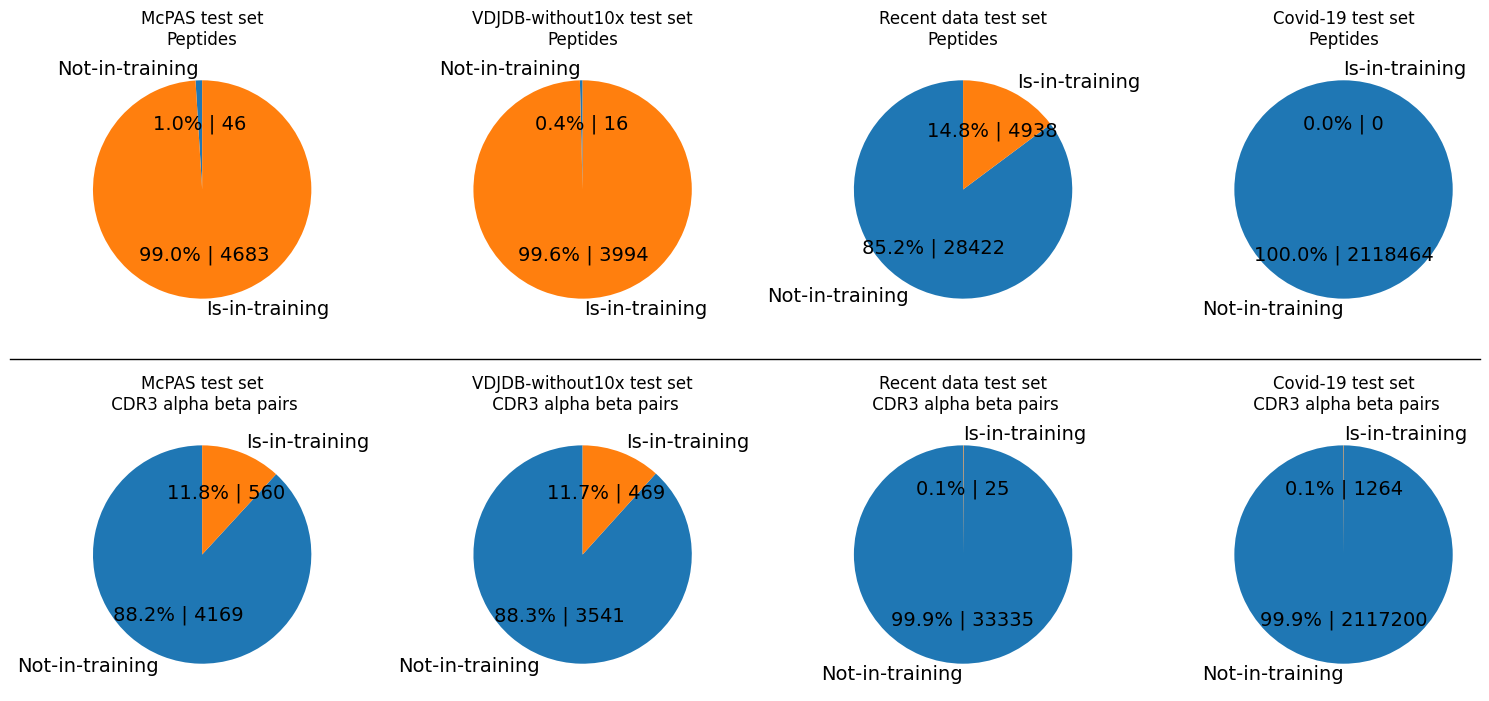

In [30]:
import matplotlib.pyplot as plt
FONTSIZE = 14

# Data for the pie charts
data_peptide = {
    'mcpas_train_samples': {'False': 46, 'True': 4683},
    'vdjdb_no10x_train_samples': {'False': 16, 'True': 3994},
    'entire-train': {'False': 28422, 'True': 4938},
    'Covid-19': {'False': 2118464, 'True': 0}
}

data_tcr = {
    'mcpas_train_samples': {"False": 4169, "True": 560},
    'vdjdb_no10x_train_samples': {"False": 3541, "True": 469},
    'entire-train': {"False": 33335, "True": 25},
    'Covid-19':  {False: 2117200, True: 1264}
}

DICT_dataset = {'mcpas_train_samples':'McPAS test set', 
                'vdjdb_no10x_train_samples':'VDJDB-without10x test set', 
                'entire-train':'Recent data test set', 
                'Covid-19':'Covid-19 test set', 
               }

# Create subplots for the pie charts
fig, axes = plt.subplots(2, len(data_peptide), figsize=(15, 7.5))

line = plt.Line2D((.01,.99),(.492,.492), color="k", linewidth=1)
fig.add_artist(line)

for i, data in enumerate([data_peptide, data_tcr]):
    # Generate pie chart for each dataset
    for j, (dataset, values) in enumerate(data.items()):
        labels = list(values.keys())
        labels = ['Not-in-training', 'Is-in-training']
        counts = list(values.values())

        # Plot the pie chart
        ax = axes[i][j]
        pie = ax.pie(counts, labels=labels, startangle=90, 
               #autopct='%1.1f%%'
               autopct=lambda pct: f'{pct:.1f}% | {int(round(pct * sum(counts) / 100.0))}',
                     textprops={'fontsize': FONTSIZE}
              )
        
        # Adjust label font size
        for label in pie[1]:
            label.set_fontsize(FONTSIZE)
        
        title = DICT_dataset[dataset] #.replace('train','test') + f' \n {sum(counts)} total interactions'
        if i==0:
            
            ax.set_title(title + '\n' + 'Peptides')
        else:
            ax.set_title(title + f'\n CDR3 alpha beta pairs')

plt.tight_layout()
plt.show()

# labels = ["# of interaction that has the same peptides of training set", 
#           "# of interaction that are not included in training set"]


In [33]:
# pd.DataFrame(temp, columns=['# of interaction that has the same CDR3ab of training set',
#     '# of interaction that has the same peptides of training set', 
#                             '# of interactions'])

## tcr a (unique)

In [35]:
what_to_see = 'tcra'

print(what_to_see)
print()
for key in ['mcpas_train_samples', 'vdjdb_no10x_train_samples', 'entire-train', 'Covid-19-train']:
    print(key)
    print("\t",
        data_dictionary[key.replace('train','test')][what_to_see].drop_duplicates()\
          .isin(data_dictionary[key][what_to_see]).value_counts().sort_index().to_dict())

tcra

mcpas_train_samples
	 {False: 500, True: 218}
vdjdb_no10x_train_samples
	 {False: 372, True: 198}
entire-train
	 {False: 4338, True: 444}
Covid-19-train
	 {False: 1480, True: 136}


## tcr b (unique)

In [36]:
what_to_see = 'tcrb'

print(what_to_see)
print()
for key in ['mcpas_train_samples', 'vdjdb_no10x_train_samples', 'entire-train', 'Covid-19-train']:
    print(key)
    print("\t",
        data_dictionary[key.replace('train','test')][what_to_see].drop_duplicates()\
          .isin(data_dictionary[key][what_to_see]).value_counts().sort_index().to_dict())

tcrb

mcpas_train_samples
	 {False: 516, True: 198}
vdjdb_no10x_train_samples
	 {False: 376, True: 196}
entire-train
	 {False: 5026, True: 148}
Covid-19-train
	 {False: 1648, True: 12}


## tcr ab (unique)

In [37]:
what_to_see = 'tcr_pairs'

print(what_to_see)
print()
for key in ['mcpas_train_samples', 'vdjdb_no10x_train_samples', 'entire-train', 'Covid-19-train']:
    print(key)
    print("\t",
        data_dictionary[key.replace('train','test')][what_to_see].drop_duplicates()\
          .isin(data_dictionary[key][what_to_see]).value_counts().sort_index().to_dict())

tcr_pairs

mcpas_train_samples
	 {False: 701, True: 132}
vdjdb_no10x_train_samples
	 {False: 578, True: 111}
entire-train
	 {False: 33165, True: 18}
Covid-19-train
	 {False: 1675, True: 1}


## peptide  (unique)

In [38]:
what_to_see = 'peptide'

print(what_to_see)
print()
for key in ['mcpas_train_samples', 'vdjdb_no10x_train_samples', 'entire-train', 'Covid-19-train']:
    print(key)
    print("\t",
        data_dictionary[key.replace('train','test')][what_to_see].drop_duplicates()\
          .isin(data_dictionary[key][what_to_see]).value_counts().sort_index().to_dict())

peptide

mcpas_train_samples
	 {False: 19, True: 171}
vdjdb_no10x_train_samples
	 {False: 8, True: 111}
entire-train
	 {False: 794, True: 44}
Covid-19-train
	 {False: 1264}


## Interactions

In [39]:
what_to_see = 'pairs'

print(what_to_see)
print()
for key in ['mcpas_train_samples', 'vdjdb_no10x_train_samples', 'entire-train', 'Covid-19-train']:
    print(key)
    print("\t",
        data_dictionary[key.replace('train','test')][what_to_see].drop_duplicates()\
          .isin(data_dictionary[key][what_to_see]).value_counts().sort_index().to_dict())

pairs

mcpas_train_samples
	 {False: 4197}
vdjdb_no10x_train_samples
	 {False: 3372}
entire-train
	 {False: 33360}
Covid-19-train
	 {False: 2118464}


# Pos Rate

In [40]:
pd.DataFrame([
    [df.sign.mean(), df.sign.sum(),
    df.shape[0]] 
    for ky, df in data_dictionary.items()
], 
    index=data_dictionary.keys(), 
    columns=['positive ratio','positive count', 'interactions']
).drop(['vdjdb_test_samples','vdjdb_train_samples']).sort_index(ascending=False) 

,positive ratio,positive count,interactions
vdjdb_no10x_train_samples,0.166957,3260.0,19526
vdjdb_no10x_test_samples,0.150374,603.0,4010
mcpas_train_samples,0.166545,3891.0,23363
mcpas_test_samples,0.151195,715.0,4729
entire-train,0.139996,16666.0,119046
entire-test,0.166667,5560.0,33360
Covid-19-train,0.139996,16666.0,119046
Covid-19-test,0.000014,30.0,2118464


In [41]:
print(
pd.DataFrame([
    [df.sign.mean(), df.sign.sum(),
    df.shape[0]] 
    for ky, df in data_dictionary.items()
], 
    index=data_dictionary.keys(), 
    columns=['positive ratio','positive count', 'interactions']
).drop(['vdjdb_test_samples','vdjdb_train_samples']).sort_index(ascending=False) .to_latex()
)

\begin{tabular}{lrrr}
\toprule
{} &  positive ratio &  positive count &  interactions \\
\midrule
vdjdb\_no10x\_train\_samples &        0.166957 &          3260.0 &         19526 \\
vdjdb\_no10x\_test\_samples  &        0.150374 &           603.0 &          4010 \\
mcpas\_train\_samples       &        0.166545 &          3891.0 &         23363 \\
mcpas\_test\_samples        &        0.151195 &           715.0 &          4729 \\
entire-train              &        0.139996 &         16666.0 &        119046 \\
entire-test               &        0.166667 &          5560.0 &         33360 \\
Covid-19-train            &        0.139996 &         16666.0 &        119046 \\
Covid-19-test             &        0.000014 &            30.0 &       2118464 \\
\bottomrule
\end{tabular}



In [42]:
pd.DataFrame([
    [df.sign.mean(), df.sign.sum(),
    df.shape[0]] 
    for ky, df in data_dictionary.items()
], 
    index=data_dictionary.keys(), 
    columns=['positive ratio','positive count', 'interactions']
).drop(['vdjdb_test_samples','vdjdb_train_samples']).sort_index(ascending=False)

,positive ratio,positive count,interactions
vdjdb_no10x_train_samples,0.166957,3260.0,19526
vdjdb_no10x_test_samples,0.150374,603.0,4010
mcpas_train_samples,0.166545,3891.0,23363
mcpas_test_samples,0.151195,715.0,4729
entire-train,0.139996,16666.0,119046
entire-test,0.166667,5560.0,33360
Covid-19-train,0.139996,16666.0,119046
Covid-19-test,0.000014,30.0,2118464


In [44]:
data_dictionary['entire-train']

dict_keys(['vdjdb_test_samples', 'vdjdb_no10x_test_samples', 'mcpas_test_samples', 'vdjdb_train_samples', 'mcpas_train_samples', 'vdjdb_no10x_train_samples', 'entire-train', 'Covid-19-train', 'Covid-19-test', 'entire-test'])

In [52]:
data_dictionary['entire-train']\
.drop_duplicates(subset=['tcrb','peptide'])\
.rename(columns={"tcrb":'CDR3', 'peptide':'Peptide'})\
.to_csv("../../PanPep/Data/entire-train.csv", index=None)

In [54]:
data_dictionary['entire-test']\
.drop_duplicates(subset=['tcrb','peptide'])\
.rename(columns={"tcrb":'CDR3', 'peptide':'Peptide'})\
.to_csv("../../PanPep/Data/recent-test.csv", index=None)

In [55]:
pd.read_csv("../../PanPep/Data/benchmark_tpp1_vdjdb.csv")

,Peptide,CDR3,Label
0,ADGLAYFRSSFKGG,CASKGGGGTGQLYF,0
1,ADGLAYFRSSFKGG,CASSLNNANSDYTF,1
2,AMFWSVPTV,CASSQDSAETLYF,0
3,AMFWSVPTV,CASSSAGAAYEQYF,0
4,AMFWSVPTV,CASSQSPGGTQYF,0
...,...,...,...
4480,YVLDHLIVV,CASSSAPEQYF,0
4481,YVLDHLIVV,CASRLQGINEKLFF,0
4482,YVLDHLIVV,CASSSSMESGNTIYF,0
4483,YVLDHLIVV,CASSLSSQNTLYF,0


In [56]:
pd.read_csv("../../PanPep/Output/benchmark_tpp1_vdjdb_output_majority.csv")

,Peptide,CDR3,Score
0,ADGLAYFRSSFKGG,CASKGGGGTGQLYF,tensor(0.0802)
1,ADGLAYFRSSFKGG,CASSLNNANSDYTF,tensor(0.1037)
2,AMFWSVPTV,CASSTRSTDTQYF,0.00076794566
3,AMFWSVPTV,CASSPLSGRVTDTQYF,0.00027134753
4,AMFWSVPTV,CASSQSPGGTQYF,0.0012794965
...,...,...,...
4480,YVLDHLIVV,CASSSRSHQPQHF,0.0472212
4481,YVLDHLIVV,CASSRSDREMFNYGYTF,0.08538617
4482,YVLDHLIVV,CSAPVPPYNEQFF,0.10723366
4483,YVLDHLIVV,CASSAGTTEVFF,0.16514081
